### This notebook will be used to explore statcast data and train a ml model to predict betting odds for different pitch outcomes

In [37]:
import pybaseball
from pybaseball import statcast
from pybaseball import  statcast_pitcher
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import beta

 # Pull Data From Statcast
 Below we pull data from statcast over a 2 year time period ((start_dt='2023-06-24', end_dt='2025-06-24')). This request may take some time and cache is enabled due to the size of this request.

In [38]:
pybaseball.cache.enable()
df = statcast(start_dt='2023-06-24', end_dt='2025-06-24')

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 493/493 [01:15<00:00,  6.52it/s]
/opt/homebrew/lib/python3.11/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


# Explore Dataset
Below we are simply looking at the features in the data set and some of the metrics related to those features. Some values such as min,max,mean, etc. are irrevelant for categorical features, but can provide some insight for the numerical features in the data set.

In [39]:
df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2483,FF,2025-06-24,94.3,-1.18,5.64,"Iglesias, Raisel",596019,628452,field_out,hit_into_play,...,1,1.31,0.7,-0.7,38.7,0.889457,-4.937905,43.384277,34.742034,26.972696
2546,FF,2025-06-24,94.3,-1.32,5.56,"Iglesias, Raisel",596019,628452,None,swinging_strike,...,1,1.28,0.76,-0.76,40.6,0.699344,10.160129,43.474862,34.859079,20.992266
2641,CH,2025-06-24,86.5,-1.51,5.44,"Iglesias, Raisel",596019,628452,None,swinging_strike,...,1,2.63,1.34,-1.34,33.9,15.702425,-1.636676,38.587292,49.084237,30.493677
2741,FF,2025-06-24,94.6,-1.46,5.44,"Iglesias, Raisel",596019,628452,None,blocked_ball,...,1,1.14,0.6,-0.6,34.1,<NA>,<NA>,<NA>,<NA>,<NA>
2939,CH,2025-06-24,88.0,-1.65,5.45,"Iglesias, Raisel",677595,628452,double,hit_into_play,...,1,2.18,1.21,-1.21,34.5,8.886125,-17.345124,20.223029,42.808848,46.358165


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1547902 entries, 2483 to 4361
Columns: 118 entries, pitch_type to intercept_ball_minus_batter_pos_y_inches
dtypes: Float64(42), Int64(59), datetime64[ns](1), object(16)
memory usage: 1.5+ GB


In [41]:
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None
):
    display(df.describe(include='all').T)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
pitch_type,1513531,18,FF,481987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_date,1547902,NaN,NaN,NaN,2024-06-24 11:12:21.865569792,2023-06-24 00:00:00,2023-10-07 00:00:00,2024-06-24 00:00:00,2025-03-16 00:00:00,2025-06-24 00:00:00,NaN
release_speed,1512461.0,<NA>,<NA>,<NA>,89.171956,31.9,84.9,90.0,94.0,105.5,6.041617
release_pos_x,1512454.0,<NA>,<NA>,<NA>,-0.840768,-5.14,-2.16,-1.53,0.79,4.71,1.867924
release_pos_z,1512454.0,<NA>,<NA>,<NA>,5.761049,0.78,5.49,5.81,6.08,8.06,0.524147
player_name,1547902,1647,"Wheeler, Zack",7050,NaN,NaN,NaN,NaN,NaN,NaN,NaN
batter,1547902.0,<NA>,<NA>,<NA>,643061.923644,408234.0,621493.0,664023.0,672761.0,828599.0,52924.850572
pitcher,1547902.0,<NA>,<NA>,<NA>,637720.770159,425794.0,607481.0,657376.0,671922.0,829272.0,55135.889025
events,400245,22,field_out,160028,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,1547902,17,ball,514866,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Mapping Outcomes to Target Features
The outcomes of the pitch are stored as strings in the 'description' and 'events' features of the data set. I need to map these strings to a new target variable 'outcomes'.

In [42]:
def map_outcome(row):
    if row["description"] == "ball":
        return "ball"
    if row["description"] == "called_strike":
        return "called_strike"
    if row["description"] == "swinging_strike":
        return "swinging_strike"
    if row["description"] == "foul":
        return "foul"

    if row["events"] == "single":
        return "single"
    if row["events"] == "double":
        return "double"
    if row["events"] == "triple":
        return "triple"
    if row["events"] == "home_run":
        return "home_run"

    if row["events"] in ["field_out", "strikeout"]:
        return "in_play_out"

    return None

df['outcome'] = df.apply(map_outcome, axis=1)

df['outcome']

df = df.reset_index(drop=True)


### Visualize the Distrubtion of Outcomes
Create a histogram to visualize the frequency of the different outcomes.

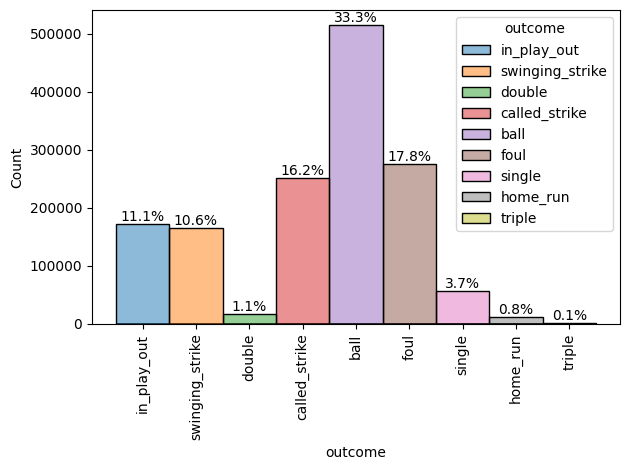

In [43]:
fig, ax = plt.subplots()
sns.histplot(data = df, ax=ax, x='outcome', hue='outcome')
plt.xticks(rotation=90)

#Calculate percentages and add labels
total = len(df['outcome'])
for p in ax.patches:
    height = p.get_height()
    if height>0:
        percentage = f'{(height / total * 100):.1f}%' # calculate percentage
        ax.text(p.get_x() + p.get_width() / 2.,
                height,
                percentage,
                ha='center', va='bottom')

plt.tight_layout()
plt.xticks(rotation=90)

plt.show()

# strike_sum = df["outcome"].isin(["called_strike", "swinging_strike"]).sum()
# balls = df['outcome'].isin(['ball']).sum()
# print(strike_sum)
# print(balls)

Above we can see that a ball is the most common outcome for a given pitch in the data set. If we were to combine 'called_strike' and 'swinging strike' into the same category 'strike', you could imagine that this category would be comparable to 'ball' in terms of frequency based on graph above.

Hitting a triple appears to be the least common outcome, followed by home_run, double, single. This means, as one who watches the MLB would have predicted, that getting on base is very difficult and for a given pitch, relatively rare. Thinking ahead, depending on what modeling technique is used, the model could be very biased towards all other categories. If it were to predict a ball or strike, the model would be correct a high percentage of the time. Basically, the model could be trained to never predict the more rare categories, which means we will have to be mindful about tactics to avoid this from happening so that the odds are increased for those rare outcomes.

# Simplify Outcomes
The eventual goal is to create a model that can predict all possible outcomes of a hit in the categories shown in the histogram above. However, it is advisable to start with a model that predicts fewer outcomes that are combinations of the more granular outcomes above. Then once we get a stable model, we can start to split the outcomes out.

In [44]:
def map_outcome_coarse(row):
    if row["description"] == "ball":
        return "ball"
    if row["description"] == "called_strike":
        return "strike"
    if row["description"] == "swinging_strike":
        return "strike"
    if row["description"] == "foul":
        return "foul"

    if row["events"] == "single":
        return "hit"
    if row["events"] == "double":
        return "hit"
    if row["events"] == "triple":
        return "hit"
    if row["events"] == "home_run":
        return "hit"

    if row["events"] in ["field_out", "strikeout"]:
        return "out"

    return None

df['outcome_coarse'] = df.apply(map_outcome_coarse, axis=1)

df['outcome_coarse']

df = df.reset_index(drop=True)

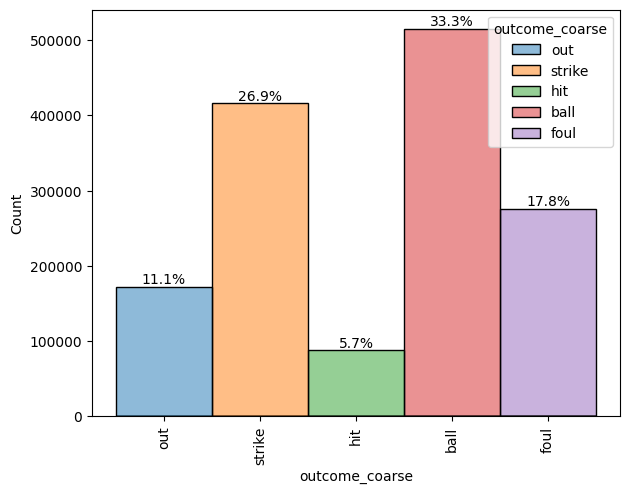

In [45]:
fig, ax = plt.subplots() #2,1, figsize=(8,10)
sns.histplot(data = df, ax=ax, x='outcome_coarse', hue='outcome_coarse')
# sns.histplot(data = df, ax=ax[1], x='outcome', hue='outcome', stat='percent')

#Calculate percentages and add labels
total = len(df['outcome_coarse'])
for p in ax.patches:
    height = p.get_height()
    if height>0:
        percentage = f'{(height / total * 100):.1f}%' # calculate percentage
        ax.text(p.get_x() + p.get_width() / 2.,
                height,
                percentage,
                ha='center', va='bottom')

plt.tight_layout()
plt.xticks(rotation=90)

plt.show()

Above, we can see the new distribution with the coarser outcomes. This helps even out strikes with balls, however, even with all the hit types (single, double, triple, HR) grouped into one 'hit' category, its still disproportionately low relative to the other outcomes. Again, just something to keep in mind when training the model down the road. 

# Player Data
Below I wanted to explore some of the player data that is provided from statcast. Specifically, they offer the statcast_pitcher data and I wanted to explore what the features of this data look like for a given player. I chose 'Clayton Kershaw' as the example pitcher to use for this. Pitcher data will have to be used to train the model, and understanding what features we have to work with is the goal here.

In [46]:
kershaw_stats = statcast_pitcher('2023-06-24', '2025-06-24', 477132)

In [47]:
kershaw_stats.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,SL,2025-06-20,86.2,1.73,5.96,"Kershaw, Clayton",695578,477132,field_out,hit_into_play,...,1.0,2.56,-0.52,-0.52,51.8,5.619273,11.288477,36.328710,37.605983,30.052124
1,CU,2025-06-20,73.6,1.56,6.12,"Kershaw, Clayton",695578,477132,None,blocked_ball,...,1.0,5.56,-0.49,-0.49,61.2,NaN,NaN,NaN,NaN,NaN
2,SL,2025-06-20,85.2,2.00,5.99,"Kershaw, Clayton",695578,477132,None,blocked_ball,...,1.0,2.57,-0.54,-0.54,54.9,NaN,NaN,NaN,NaN,NaN
3,SI,2025-06-20,89.2,2.78,5.45,"Kershaw, Clayton",695578,477132,None,called_strike,...,1.0,1.58,0.41,0.41,36.4,NaN,NaN,NaN,NaN,NaN
4,SL,2025-06-20,85.6,1.73,6.01,"Kershaw, Clayton",642708,477132,field_out,hit_into_play,...,2.0,2.50,-0.62,0.62,56.2,3.848913,-17.880564,39.672384,29.617932,28.859536


# Batter Feature Engineering
Batter statistics will be important for model training and many stats (if any) are not offered by the raw data from statcast and must be calculated. For example, for a given player. The features that may be correlated to the odds of a given outcome were engineered and so far include:
- 'batter_contact_rate': the proportion of a batter making contact with the ball (either foul tip or in play hit)
- 'batter_contact_amt': the number of times a batter has hit the ball
* this is important because if a batter has a high contact rate, but has only been up to bat a couple of times, the model doesn't know that and would just think the batter is either very good (he hit on both opportunities he has had as an MLB batter) or very bad (the batter didn't make contact on either hit). It's important to consider this for all player stats moving forward that could be skewed by the amount that player has played. There are likely other (possibly better) tactics for dealing with these scenarios.



In [48]:
df["batter_contact_rate"] = (
    df.groupby("batter")["description"]
      .transform(lambda x: x.isin(["foul", "in_play"]).expanding().mean())
)

In [49]:
df["batter_contact_rate"] = (
    df.groupby("batter")["description"]
      .transform(lambda x: x.isin(["foul", "in_play"]).expanding().mean())
)

In [50]:
df["batter_contact_amt"] = (
    df.groupby("batter")["description"]
      .transform(lambda x: x.isin(["foul", "in_play"]).expanding().sum())
)

In [51]:
with pd.option_context('display.max_rows', None):
    display(df.skew(numeric_only=True))

release_speed                               -0.771177
release_pos_x                                0.889086
release_pos_z                               -1.546266
batter                                      -1.291165
pitcher                                     -1.200223
spin_dir                                         <NA>
spin_rate_deprecated                             <NA>
break_angle_deprecated                           <NA>
break_length_deprecated                          <NA>
zone                                        -0.381717
hit_location                                 0.033245
balls                                        0.796915
strikes                                      0.189895
game_year                                    0.003244
pfx_x                                        0.174146
pfx_z                                       -0.550458
plate_x                                      0.026669
plate_z                                     -0.063305
on_3b                       

# Create data
game_id
pitch_id
pitch_timestamp
inning
is_top_inning
balls
strikes
outs
batter_id
pitcher_id
batter_hand
pitcher_hand
description            # actual outcome (label)


# Strike Rate by Pitcher
Below I create a dataframe that captures strike rate data for each pitcher. The new dataframe has features for strike_rate, totatl_pitches, and strike_count. This is done using group by on pitcher id from the original dataframe and aggregation functions.

In [54]:
STRIKE_EVENTS = {
    "called_strike",
    "swinging_strike",
    "foul"
}

strike_rate_by_pitcher = (
    # assign creates new, temporary copy of df with is_strike column
    df.assign(is_strike=df["outcome_coarse"].isin(["strike", "foul"]))
      .groupby("pitcher", as_index=False) # want to get strike rate for each ind. pitcher, so group by pitcher (player id)
      .agg( # agg will perform specified aggregate measurements for each pitcher
          strike_rate=("is_strike", "mean"), # get strike rate (mean of strikes thrown)
          total_pitches=("is_strike", "size"), # get number of pitches thrown
          strike_count=("is_strike", "sum") # get strike count
      )
)

strike_rate_by_pitcher.head()

,pitcher,strike_rate,total_pitches,strike_count
0,425794,0.375723,1038,390
1,425844,0.402323,947,381
2,434378,0.456100,4795,2187
3,445276,0.481235,1652,795
4,445926,0.437076,1327,580


<function matplotlib.pyplot.show(close=None, block=None)>

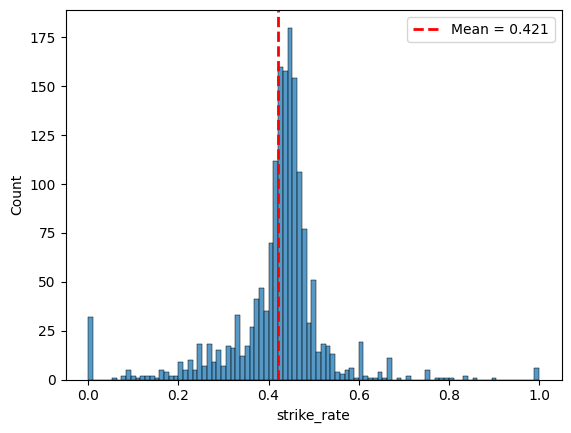

In [55]:
import numpy as np
from scipy.stats import norm

fig, ax = plt.subplots()
sns.histplot(data=strike_rate_by_pitcher, ax=ax, x='strike_rate')
mean_strike_rate = strike_rate_by_pitcher['strike_rate'].mean()
std_strike_rate = strike_rate_by_pitcher["strike_rate"].std()
ax.axvline(
    mean_strike_rate,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean = {mean_strike_rate:.3f}"
)

ax.legend()
plt.show

# Empirical Bayes Shrinkage
We want to adjust strike rates for each individual player to be closer to the league-wide average strike rate. This is especially important for pitchers with little data as their strike rates offer noise rather than helpful statistics for the model. For example, if a pitcher has only thrown 30 pitches and has an 80% strike rate, there is great uncertainty around that estimate due to the lack of data for that pitcher. A good strategy is to use empirical bayes shrinkage where we use a Beta distribution of the league mean strike rate to shrink each pitchers strike rate closer to this mean. Pitchers with less pitches thrown will have greater shrinkage to their estimated strike rates than those who have thrown more pitches.

In [60]:
# Binary indicator for strike
df['is_strike'] = df['outcome_coarse'].isin(['strike', 'foul']).astype(int)


league_strike_rate = df['is_strike'].mean()

print(league_strike_rate)

0.447176242423616


### Estimate prior strength (α + β)

In [61]:
# Filter out extremely small samples
min_pitches = 100
eligible = strike_rate_by_pitcher[strike_rate_by_pitcher['total_pitches'] >= min_pitches]

# get mean and variance from data
mean_rate = eligible['strike_rate'].mean()
var_rate = eligible['strike_rate'].var()

print(mean_rate)

0.4410226763561572


### For a Beta distribution:

Var(𝜃)=𝜇(1−𝜇)/𝛼+𝛽+1

### Solve for prior sample size: 
𝑚=𝛼+𝛽

In [62]:
prior_strength = (
    mean_rate * (1 - mean_rate) / var_rate
) - 1

prior_strength = max(prior_strength, 1)  # numerical safety

### Compute α and β

In [63]:
alpha = mean_rate * prior_strength
beta_param = (1 - mean_rate) * prior_strength

### Visualize Beta Distribution of League Strike Rate
Below we can see a graph of the beta distribution given the alpha and beta parameters calculated using the existing league data (method of moments). This is a probability density graph showing the probability of different strike rates, which we are estimating to the be the probability of a random pitcher throwing a strike given the league data. This is our prior. We will use this to calculate posteriers (shrunk strike rates) for each pitcher in the league.

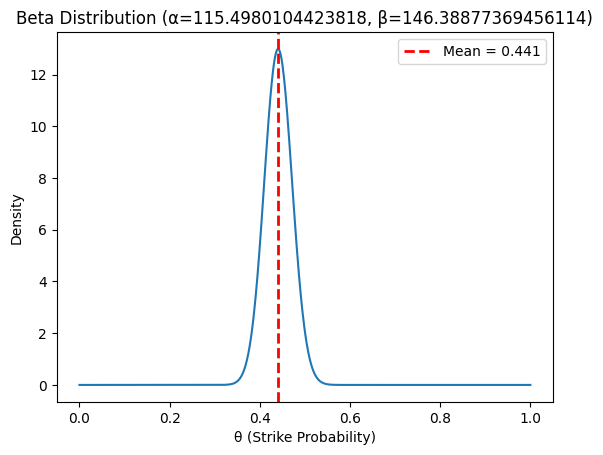

In [64]:
# Generate x values (a smooth range from 0 to 1)
x = np.linspace(0, 1, 1000)

# Beta PDF
y = beta.pdf(x, alpha, beta_param)

# Plot
plt.figure()
plt.plot(x, y)
plt.xlabel("θ (Strike Probability)")
plt.ylabel("Density")
plt.title(f"Beta Distribution (α={alpha}, β={beta_param})")
plt.axvline(
    mean_rate,
    linestyle="--",
    linewidth=2,
    label=f"Mean = {mean_rate:.3f}",
    color='red'
)
plt.legend()
plt.show()

# Apply Empirical Bayes Shrinkage
Now that we have our prior calculated, it is time to shrink each pitchers strike rate closer to the league average using these calculated parameters and Empirical Bayes Shrinkage.

In [65]:
strike_rate_by_pitcher['strike_rate_eb'] = (
    (alpha + strike_rate_by_pitcher['strike_count']) /
    (alpha + beta_param + strike_rate_by_pitcher['total_pitches'])
)

strike_rate_by_pitcher.head()

,pitcher,strike_rate,total_pitches,strike_count,strike_rate_eb
0,425794,0.375723,1038,390,0.388878
1,425844,0.402323,947,381,0.410707
2,434378,0.456100,4795,2187,0.455319
3,445276,0.481235,1652,795,0.475732
4,445926,0.437076,1327,580,0.437727


### Frequency Histogram of Empirical Bayes Shrunk Strike Rates

<function matplotlib.pyplot.show(close=None, block=None)>

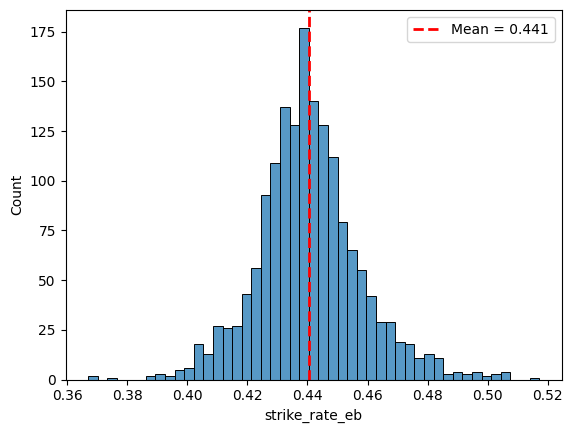

In [66]:
fig, ax = plt.subplots()
sns.histplot(data=strike_rate_by_pitcher, ax=ax, x='strike_rate_eb')
mean_strike_rate = strike_rate_by_pitcher['strike_rate_eb'].mean()
std_strike_rate = strike_rate_by_pitcher["strike_rate_eb"].std()
ax.axvline(
    mean_strike_rate,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean = {mean_strike_rate:.3f}"
)

ax.legend()
plt.show

### Example of Shrinkage With Strike Rate
Below we will find a pitcher with noisy data, and we will visualize the impact of applying shrinkage to this pitcher.

In [67]:
# noisy pitcher data
noisy_pitchers = strike_rate_by_pitcher[
    (strike_rate_by_pitcher["strike_rate"] >= 0.60) &
    (strike_rate_by_pitcher["total_pitches"] > 5)
]

noisy_pitchers.head()

,pitcher,strike_rate,total_pitches,strike_count,strike_rate_eb
147,592346,0.600000,25,15,0.454876
607,663500,0.617647,34,21,0.461318
626,663681,0.600000,10,6,0.446870
660,664092,0.652174,23,15,0.458070
692,665178,0.625000,8,5,0.446476


In [68]:
noisy_pitcher = noisy_pitchers[noisy_pitchers['pitcher']==681407]
noisy_pitcher.head()

,pitcher,strike_rate,total_pitches,strike_count,strike_rate_eb
1153,681407,0.75,8,6,0.450181


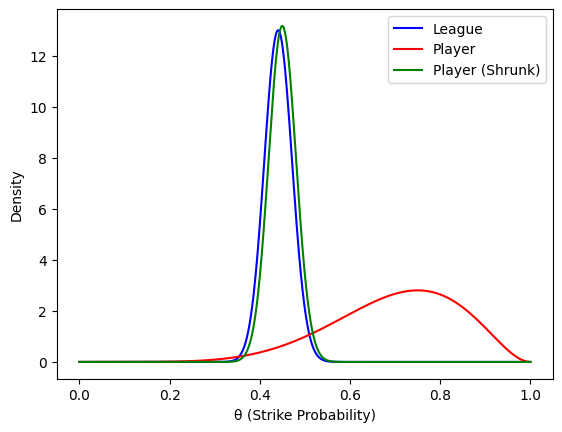

In [69]:
fig, ax = plt.subplots()
x = np.linspace(0, 1, 1000)
# Beta PDF of League Data
y = beta.pdf(x, alpha, beta_param)
#Beta PDF of Noisy Player Data
y_noisy= beta.pdf(x,noisy_pitcher['strike_count']+1,noisy_pitcher['total_pitches']-noisy_pitcher['strike_count']+1)
# Beta PDF of Shrunk Strike Rate
y_shrunk = beta.pdf(
    x, 
    alpha + noisy_pitcher['strike_count'],
    beta_param + noisy_pitcher["total_pitches"] - noisy_pitcher["strike_count"]
)
sns.lineplot(x=x,y=y,ax=ax,color='blue', label="League")
sns.lineplot(x=x,y=y_noisy,ax=ax,color='red', label="Player")
sns.lineplot(x=x,y=y_shrunk,ax=ax,color='green', label="Player (Shrunk)")
ax.set_xlabel("θ (Strike Probability)")
ax.set_ylabel("Density")
ax.legend()
plt.show()


Above we can see that pitcher 675527 has a strike rate of greater than .80 because he has thrown 7 total pitches in the league and 6 of them were strikes, we want to move this pitchers strike rate towards the league average of ~0.265.


In [70]:
import numpy as np
from scipy.special import betaln
from scipy.optimize import minimize

pitchers = strike_rate_by_pitcher.copy()

y = pitchers["strike_count"].values
n = pitchers["total_pitches"].values

def neg_log_marginal_likelihood(params, y, n):
    alpha, beta = params

    # enforce positivity
    if alpha <= 0 or beta <= 0:
        return np.inf

    ll = (
        betaln(y + alpha, n - y + beta)
        - betaln(alpha, beta)
    ).sum()

    return -ll

# sensible initialization
mean_rate = (y / n).mean()
init_strength = 100  # neutral starting point

init_alpha = mean_rate * init_strength
init_beta = (1 - mean_rate) * init_strength

result = minimize(
    neg_log_marginal_likelihood,
    x0=[init_alpha, init_beta],
    args=(y, n),
    bounds=[(1e-6, None), (1e-6, None)],
    method="L-BFGS-B"
)

alpha_hat, beta_hat = result.x

pitchers["strike_rate_eb"] = (
    (alpha_hat + pitchers["strike_count"]) /
    (alpha_hat + beta_hat + pitchers["total_pitches"])
)


<function matplotlib.pyplot.show(close=None, block=None)>

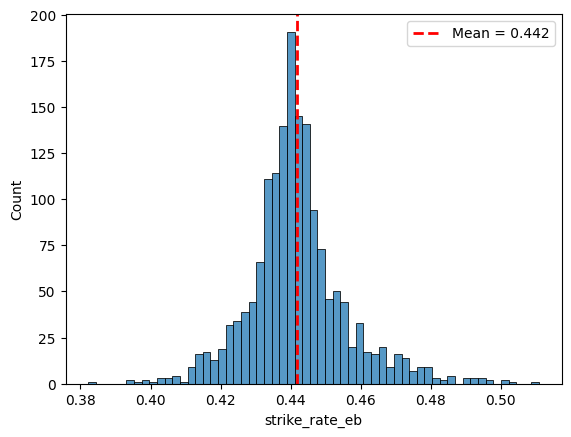

In [71]:
fig, ax = plt.subplots()
sns.histplot(data=pitchers, ax=ax, x='strike_rate_eb')
mean_strike_rate = pitchers['strike_rate_eb'].mean()
std_strike_rate = pitchers["strike_rate_eb"].std()
ax.axvline(
    mean_strike_rate,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean = {mean_strike_rate:.3f}"
)

ax.legend()
plt.show

In [72]:
noisy_pitcher = pitchers[pitchers['pitcher']==681407]
noisy_pitcher.head()

,pitcher,strike_rate,total_pitches,strike_count,strike_rate_eb
1153,681407,0.75,8,6,0.44683


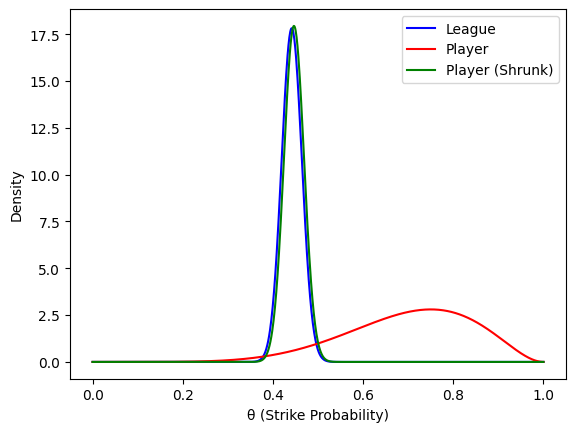

In [73]:
fig, ax = plt.subplots()
x = np.linspace(0, 1, 1000)
# Beta PDF of League Data
y = beta.pdf(x, alpha_hat, beta_hat)
#Beta PDF of Noisy Player Data
y_noisy= beta.pdf(x,noisy_pitcher['strike_count']+1,noisy_pitcher['total_pitches']-noisy_pitcher['strike_count']+1)
# Beta PDF of Shrunk Strike Rate
y_shrunk = beta.pdf(
    x, 
    alpha_hat + noisy_pitcher['strike_count'],
    beta_hat + noisy_pitcher["total_pitches"] - noisy_pitcher["strike_count"]
)
sns.lineplot(x=x,y=y,ax=ax,color='blue', label="League")
sns.lineplot(x=x,y=y_noisy,ax=ax,color='red', label="Player")
sns.lineplot(x=x,y=y_shrunk,ax=ax,color='green', label="Player (Shrunk)")
ax.set_xlabel("θ (Strike Probability)")
ax.set_ylabel("Density")
ax.legend()
plt.show()
